
Bad key "text.kerning_factor" on line 4 in
C:\Users\nerpa\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


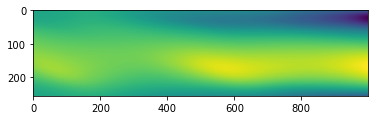

In [1]:
import numpy as np

from weight import *
from utils import save, load
from library import *
from process_library_terms import *
import matplotlib.pyplot as plt

import h5py
#with h5py.File('NSE2D/uvp-0.001.mat', 'r') as mat:
with h5py.File('NSE2D/uvp2-0.001.mat', 'r') as mat:
#with h5py.File('NSE2D/tgv-0.001.mat', 'r') as mat:
    P = np.array(mat['P'])
    U = np.array(mat['U'])
    V = np.array(mat['V'])
    
#import netCDF4 as nc
#fn = '/path/to/file.nc4'
#ds = nc.Dataset(fn)

# for some reason, we need to fix the order of the axes
P = np.transpose(P, (1, 2, 0))
U = np.transpose(U, (1, 2, 0))
V = np.transpose(V, (1, 2, 0))

Lx = 4; Ly = 4; Lt = 1;
#Nx = 512; Ny = Nx; Nt = 1000; # normal resolution
Nx = 256; Ny = Nx; Nt = 1000; # half resolution
#Nx = 256; Ny = Nx; Nt = Nx # analytical
dx = Lx/Nx; dy = Ly/Ny; dt = Lt/Nt;

# don't use MATLAB data
#x = np.arange(0, 4, dx); y = np.arange(0, 4, dy); t = np.arange(0, 0.2, dt)
#xg, yg = np.meshgrid(x, y)
#U = 4*np.einsum('i,j,k->ijk', np.sin(4*x), np.cos(4*y), np.exp(-0.32*t))
#V = -4*np.einsum('i,j,k->ijk', np.cos(4*x), np.sin(4*y), np.exp(-0.32*t))
#P = 4*np.einsum('ij, k->ijk', np.cos(8*xg)+np.cos(8*yg), np.exp(-0.64*t))

fig, ax= plt.subplots(figsize=(6,6))
ax.imshow(P[:, 128, :])

0.027839316314777207

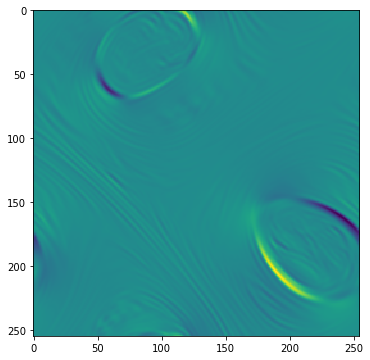

In [2]:
fig, ax= plt.subplots(figsize=(6,6))
dU = np.diff(U[:, :, -1], axis=0)
dV = np.diff(V[:, :, -1], axis=1)
ax.imshow(dU[:,1:]+dV[1:,:])
np.max(dU[:,1:]+dV[1:,:])

In [3]:
uobs = Observable('u', 1)
pobs = Observable('p', 0)
observables = [uobs, pobs]

u = np.concatenate([U[:, :, :, np.newaxis], V[:, :, :, np.newaxis]], axis=3)

### define all parameters and "make library"
terms = generate_terms_to(3, observables=observables, max_observables=3)
terms0 = []
terms1 = []
for term in terms:
    if term.rank==0:
        terms0.append(term)
    else:
        terms1.append(term)

world_size = np.array(U.shape)
m = 12
qmax = 1
nweights = qmax**4
ndomains = 30 #250
wx = 64
wt = 50
pad = 0


In [4]:
#%%prun

# fix random seed
np.random.seed(1)

data_dict = {'p': P, 'u': u}

dxs = [dx, dy, dt]

scale_dict = find_scales(data_dict)

char_sizes0 = [get_char_size(term, scale_dict, dx, dt) for term in terms0]
char_sizes1 = [get_char_size(term, scale_dict, dx, dt) for term in terms1]

weights = []
dxs_weight = [(wx-1)/2*dx, (wx-1)/2*dx, (wt-1)/2*dt] # grid spacing used by weight function

#for domain in domains:
for q1 in range(qmax):
    for q2 in range(qmax):
        for q3 in range(qmax):
            for q4 in range(qmax):
                weights.append(Weight([m]*3, [q1, q2, q3], [0]*3, dxs=dxs_weight))
#domains = domains*nweights

# make domains and "count" density
domains = make_domains([wx, wx, wt], world_size, ndomains, pad)

Q0 = make_library(terms0, data_dict, weights, domains, 0, dxs, debug=False)#, by_parts=False)
Q1 = make_library(terms1, data_dict, weights, domains, 1, dxs, debug=False)#, by_parts=False)

In [11]:
from identify_models import *

opts = dict()
opts['threshold'] = "'threshold'"
opts['gamma'] = 2
opts['verbose'] = False
opts['delta'] = 1e-8 # apparently this reaches machine precision as the relative error
opts['char_sizes'] = char_sizes0
opts1 = opts.copy()
opts1['char_sizes'] = char_sizes1
#eqs0, lambdas0, derived_eqs0, excluded_terms = identify_equations(Q0, opts, terms0, observables, threshold=1e-5, 
#                       max_complexity=None, max_equations=999, timed=True)
#print(excluded_terms)
#eqs1, lambdas1, derived_eqs1, excluded_terms = identify_equations(Q1, opts1, terms1, observables, threshold=1e-5, 
#                       max_complexity=None, max_equations=999, timed=True, excluded_terms=excluded_terms)
#print(excluded_terms)
eqs, lambdas, derived_eqs, excluded_terms = interleave_identify([Q0, Q1], [opts, opts1], [terms0, terms1],
                                                                observables, threshold=1e-5)

In [15]:
from sparse_reg import *
#from ipynb.fs.full.sparse_reg import *
opts = dict()
#opts['threshold'] = "'pareto'"
#opts['verbose'] = True
#opts['brute_force'] = False
opts['threshold'] = "'threshold'"
opts['n_terms'] = len(terms0)
opts['gamma'] = 2
opts['verbose'] = False
opts['delta'] = 1e-8 #apparently this reaches machine precision as the relative error
opts['char_sizes'] = char_sizes0
#Xi, lambd, best_term, lambda1 = sparse_reg(Q0, opts)
Xi, lambd, best_term, lambda1 = sparse_reg(Q0, **opts)

In [16]:
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {terms0[i]}")
print("Model residual:", lambd)
print("One-term model residual:", lambda1)
print(f"Best term (#{best_term}):", terms0[best_term])

[Term 1] 1.0 * dj u_j
Model residual: 8.240729323952344e-13
One-term model residual: 8.240729323952344e-13
Best term (#1): dj u_j


In [17]:
opts['char_sizes'] = char_sizes1
#Xi, lambd, best_term, lambda1 = sparse_reg(Q1, opts)
Xi, lambd, best_term, lambda1 = sparse_reg(Q1, **opts)

In [18]:
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {terms1[i]}")
print("Model residual:", lambd)
print("One-term model residual:", lambda1)
print("Best term:", terms1[best_term])

[Term 0] 8.183948874387479e-11 * u_i
[Term 1] 1.0 * di dj u_j
Model residual: 3.744067708030526e-08
One-term model residual: 2.0332061091043608e-07
Best term: di dj u_j


In [19]:
avoid = []
avoid.append(Xi)
opts['avoid'] = avoid
opts['verbose'] = False
Xi, lambd, best_term, lambda1 = sparse_reg(Q1, **opts)
#Xi, lambd, best_term, lambda1 = sparse_reg(Q1, opts)
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {terms1[i]}")
print("Model residual:", lambd)
print("One-term model residual:", lambda1)
print("Best term:", terms1[best_term])

[Term 2] -1.0026580431521679e-05 * dj^2 u_i
[Term 3] 0.9999998392169889 * dt u_i
[Term 6] 1.0 * dj u_i * u_j
[Term 8] 0.9999999748754661 * di p
Model residual: 4.190248170688211e-06
One-term model residual: 8.988423392599119e-06
Best term: dj u_j * u_i


In [20]:
for term, size in zip(terms0, char_sizes0):
    print(term, size)
for term, size in zip(terms1, char_sizes1):
    print(term, size)

1 1
dj u_j 0.036687726462512296
dt dj u_j 3.6687726462512294e-05
u_j * u_j 7.75596957879523
dt u_j * u_j 0.0065391126918544346
p 11.909507841829365
dj^2 p 0.0020416148869192457
dt p 0.00836245457682123
dt^2 p 8.36245457682123e-06
p * dj u_j 0.4369327660041809
dj p * u_j 0.3638914456193968
p * u_j * u_j 92.36978051965177
p * p 141.83637703459513
dt p * p 0.0995927183595943
p * p * p 1689.2014445501773
u_i 2.784954143032741
di dj u_j 0.0005732457259767546
dj^2 u_i 0.0005732457259767546
dt u_i 0.002348014493600787
dt^2 u_i 2.3480144936007867e-06
di u_j * u_j 0.10217363581022555
dj u_i * u_j 0.10217363581022555
dj u_j * u_i 0.10217363581022555
di p 0.13066335276283172
dt di p 0.00013066335276283171
p * u_i 33.167433205583606
p * dt u_i 0.02796369702426758
dt p * u_i 0.023289052519641393
di p * p 1.556136224368661
p * p * u_i 395.00780585524967
